<h1><center>Inteligencia Artificial</center></h1>


<h2><center>Tarea 5 - Inferencia Bayesiana y EDA (Exploración de Datos)</center></h2>

---

#### El **objetivo** de esta tarea es realizar un análisis exploratorio básico sobre el conjunto de datos proporcionado (pedidos de clientes a lo largo del tiempo). 


* Además, deberán agregar su informacción correspondiente del equipo que hayan formado, así como el link de github correspondiente al cual cargarán la notebook (ejecutada previamente), para visualizar las respuestas.


<h3>Integrantes</h3>
<ul>
    <li>Alejandro Gutierrez </li>
    <li>Eduardo Badillo </li>
    <li>Emilio Hernandez</li>
</ul>

### Objetivo

Predecir qué productos estarán en el próximo pedido de un usuario. El conjunto de datos es anónimo y contiene una muestra de más de 3 millones de pedidos de comestibles de más de 200,000 usuarios de Instacart.

Para cada usuario se entregan 4 y 100 de sus pedidos, con la secuencia de productos comprados en cada pedido

<img src="https://shukka.com/img/xeda.PNG.pagespeed.ic.MVCnc5-70D.png" />

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
from subprocess import check_output
print(check_output(["ls", "../Tarea 5/"]).decode("utf8"))

CalledProcessError: Command '['ls', '../Tarea 5/']' returned non-zero exit status 1.

In [4]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
aisles_df = pd.read_csv("aisles.csv")
deparments_df = pd.read_csv("departments.csv")
orders_df = pd.read_csv("orders.csv") 
products_df = pd.read_csv("products.csv")
departments_df = pd.read_csv("departments.csv")

In [5]:
orders_df.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [6]:
order_products_train_df.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [7]:
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

## ¿Qué contiene cada archivo?

### Los archivos contienen los datos históricos de ventas de una tienda. 



-----

Como se mencionó anteriormente, en este conjunto de datos, se dan de 4 a 100 pedidos de un cliente (lo veremos más adelante) y necesitamos predecir los productos que se volverán a ordenar. Así que el último pedido del usuario se ha extraído y dividido en conjuntos de prueba y de entrenamiento. 

Todas las informaciones de pedidos anteriores del cliente están presentes en el archivo order_products_prior. También podemos notar que hay una columna en el archivo orders.csv llamada eval_set que nos dice a cuál de los tres conjuntos de datos (previo, entrenamiento o prueba) va la fila dada.

-----

Primero obtengamos el recuento de filas en cada uno de los tres conjuntos.

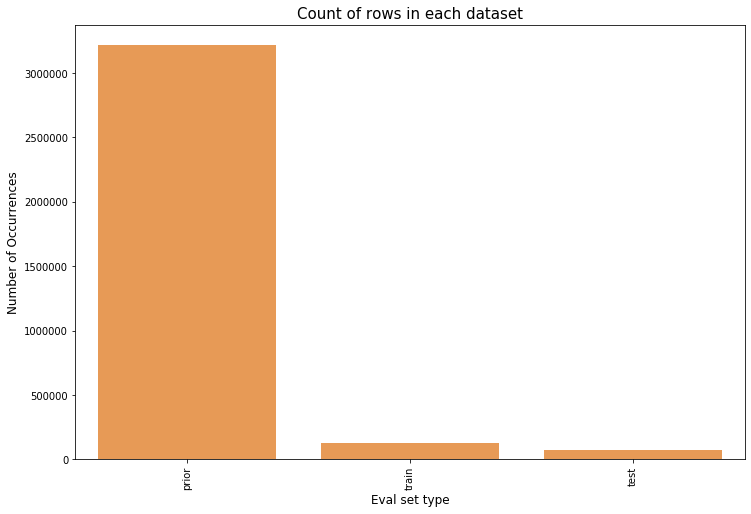

In [8]:
cnt_srs = orders_df.eval_set.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [9]:
def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

# ¿Qué significan los valores anterior? Suponiendo que teníamos un total de clientes...

### Significan la cantidad de datos que tenemos en cada tipo de data set. Los anteriores, los de entrenamiento y los de prueba.

Ahora validemos la afirmación de que se dan de 4 a 100 pedidos de un cliente.

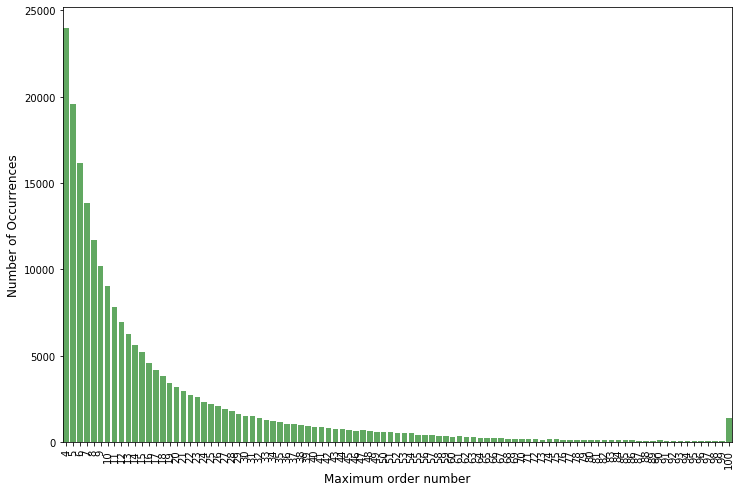

In [10]:
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Por lo tanto, no hay pedidos de menos de 4 y tiene un límite máximo de 100 como se indica en la página de datos.

Ahora veamos cómo cambia el hábito de hacer pedidos con el día de la semana.

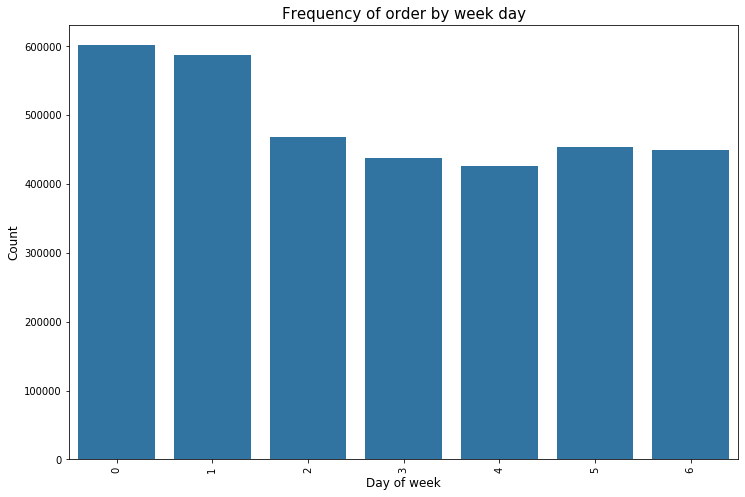

In [11]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

## ¿Cuáles són los días con mayor y menor cantidad de pedidos?

### Lunes mayor y viernes menor

Ahora veremos cómo es la distribución con respecto a la hora del día.

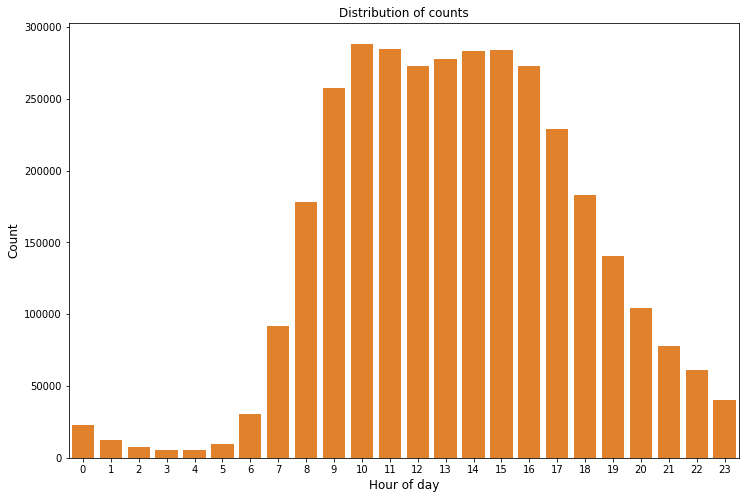

In [12]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Distribution of counts")
plt.show()

# ¿En qué periodo de tiempo se realiza la mayor cantidad de pedidos? 

### Entre las 9 y 10 de la mañana

Ahora combinemos el día de la semana y la hora del día para ver la distribución.

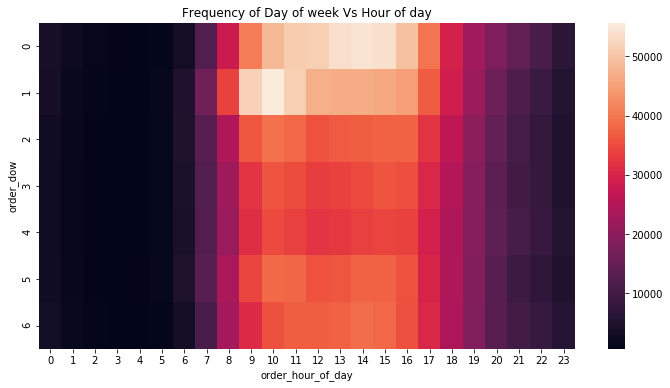

In [13]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

# ¿Cuándo es el mejor momento para realizar pedidos acorde a lo anterior?

---

### Entre las 3 y 4 de la mañana de cualquier día

Ahora revisemos el intervalo de tiempo entre los pedidos.

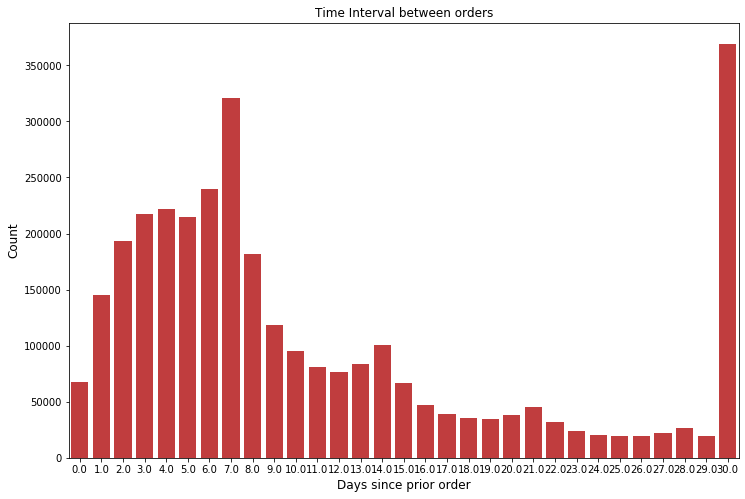

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title("Time Interval between orders")
plt.show()

In [15]:
orders_df['days_since_prior_order'].describe()

count    3.214874e+06
mean     1.111484e+01
std      9.206737e+00
min      0.000000e+00
25%      4.000000e+00
50%      7.000000e+00
75%      1.500000e+01
max      3.000000e+01
Name: days_since_prior_order, dtype: float64

# Parece que los clientes hacen pedidos... ¿cada cuánto?

### La distribución muestra las mayores frecuencias en intervalos de 7 días, siendo este el segundo cuartil de la distribución. El promedio general es cada 11 días.

# Según la tendencia, ¿hay otros días que muestren picos pequeños?

### Hay picos de frecuencias considerables en 14 y 21 días. 

Dado que nuestro objetivo es averiguar los reordenamientos, veamos el porcentaje de reorden en la serie anterior y la serie de trenes.

In [16]:
# percentage of re-orders in prior set #
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

In [17]:
# percentage of re-orders in train set #
order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

0.5985944127509629

## ¿Qué significan los valores anteriores?

### El número de registros re-ordenados sobre el total de registros en cada dataframe. Es un porcentaje de reordenamientos en cada df.

### No hay productos reordenados:

Ahora que hemos visto que el 59% de los productos se vuelven a pedir, también habrá situaciones en las que no se vuelva a pedir ninguno de los productos. Comprobemos eso ahora.

In [18]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [19]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1

In [20]:
grouped_df

order_id  reordered
0               2          1
1               3          1
2               4          1
3               5          1
4               6          0
...           ...        ...
3214869   3421079          0
3214870   3421080          1
3214871   3421081          0
3214872   3421082          1
3214873   3421083          1

[3214874 rows x 2 columns]

In [21]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.93444
0    0.06556
Name: reordered, dtype: float64

# ¿Y en esta sección?

### Es el porcentaje de los pedidos reordenados más de 1 vez en cada dataframe.

Ahora veamos la cantidad de productos comprados en cada pedido.

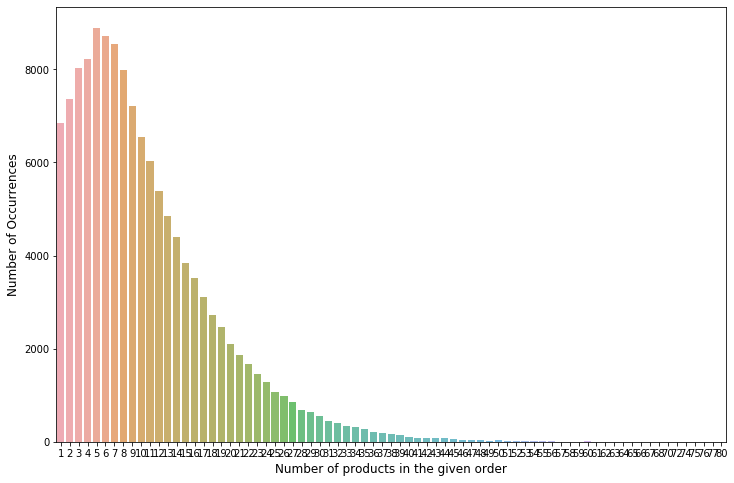

In [22]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.show()

# ¿Cuál es el valor más alto?

### 5

---

Antes de explorar los detalles del producto, veamos también los otros tres archivos.

In [23]:
products_df.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [24]:
aisles_df.head()

aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation

In [25]:
departments_df.head()

department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

Ahora fusionemos estos detalles del producto con los detalles de order_prior.

In [26]:
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered           product_name  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id  department_id               aisle  department  
0        86             16                eggs  dairy eggs  
1        83              4    fresh vegetables     produce  
2       104             13   spices seasonings      pantry  
3        19             13       oils vinegars      pantry  
4        17             13  baking ingredients      pantry

In [29]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

product_name  frequency_count
0                     Banana           472565
1     Bag of Organic Bananas           379450
2       Organic Strawberries           264683
3       Organic Baby Spinach           241921
4       Organic Hass Avocado           213584
5            Organic Avocado           176815
6                Large Lemon           152657
7               Strawberries           142951
8                      Limes           140627
9         Organic Whole Milk           137905
10       Organic Raspberries           137057
11      Organic Yellow Onion           113426
12            Organic Garlic           109778
13          Organic Zucchini           104823
14       Organic Blueberries           100060
15            Cucumber Kirby            97315
16        Organic Fuji Apple            89632
17             Organic Lemon            87746
18  Apple Honeycrisp Organic            85020
19    Organic Grape Tomatoes            84255

# ¿Qué podemos inferir de los resultados anteriores?


### Los productos frescos y naturales de consumo son los que más se venden

---

Ahora echemos un vistazo a los pasillos importantes.

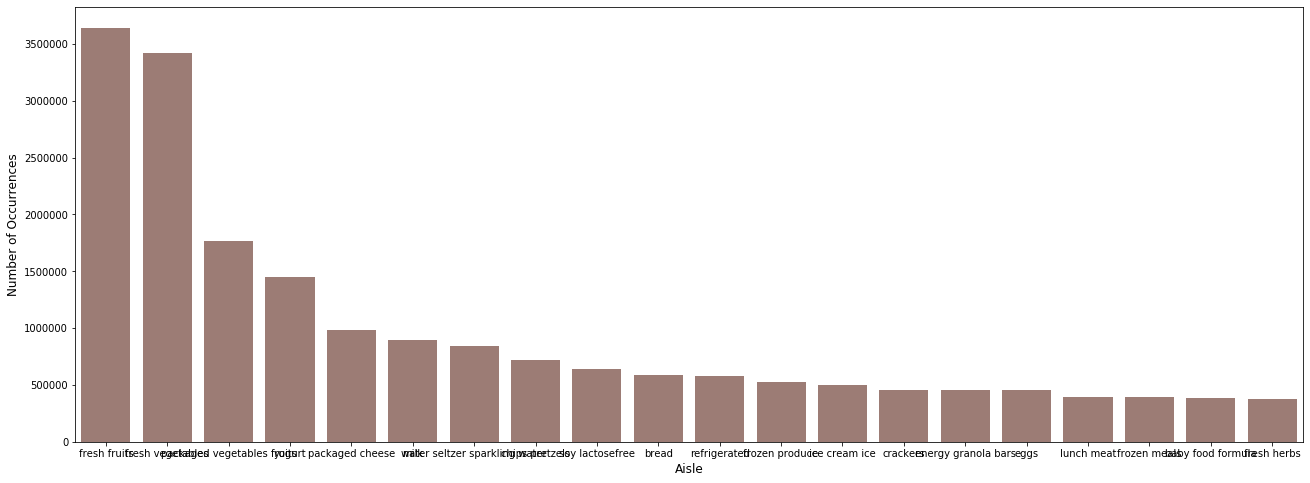

In [30]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)
plt.figure(figsize=(22,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.show()

# ¿Cuáles son los pasillos con mayor valor?

### Fresh Fruits & Vegetables

----

### Distribución departamental:

Veamos ahora la distribución inteligente del departamento.


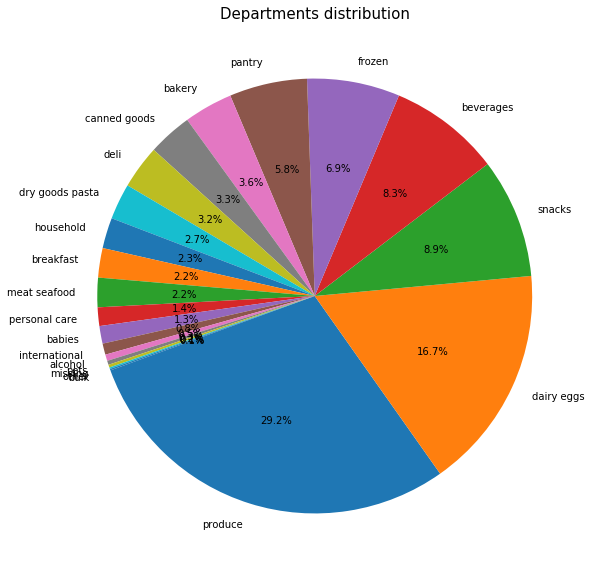

In [32]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

# ¿Cuál es el departamento más grande? y ¿por cuales es seguido?

### Produce seguido por Dairy eggs y Snack

---

### Relación de pedidos por departamento:

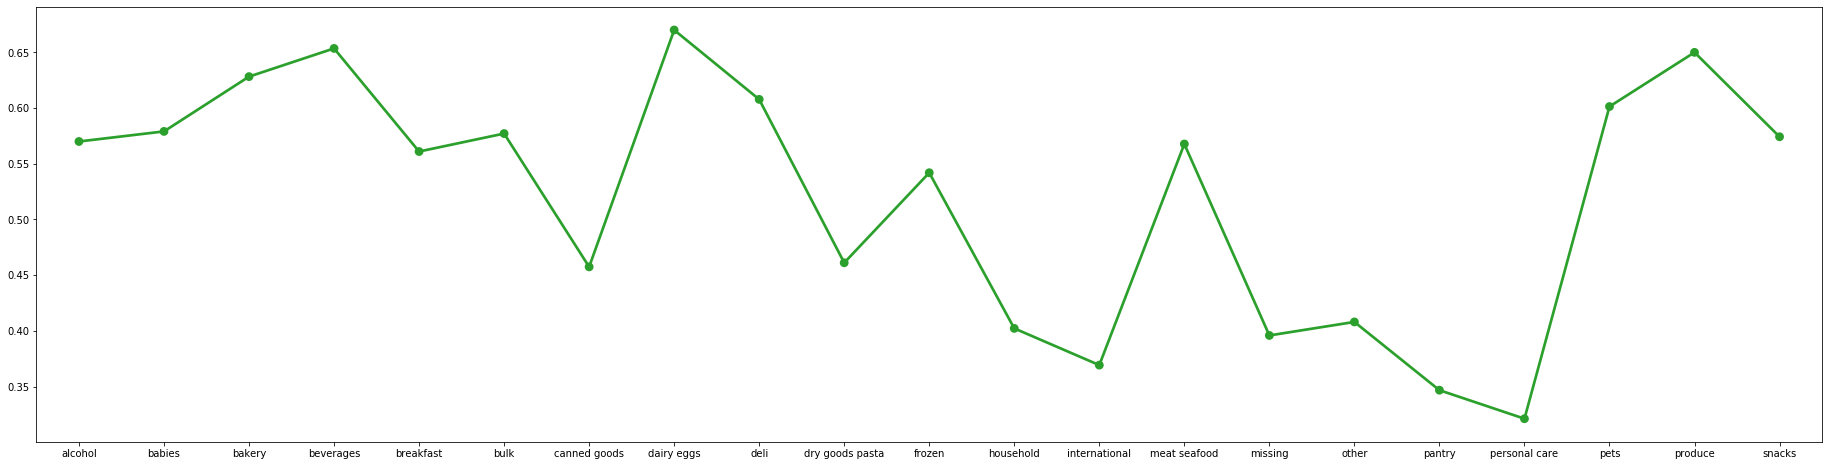

In [35]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df2 = grouped_df.copy()
plt.figure(figsize=(32,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.show()

# ¿Cuáles son los departamentos con mayor y menor cantidad de proporción de pedidos?

### Mayor: Dairy eggs
### Menor: Personal Care

---


### Pasillo - Relación de pedidos:

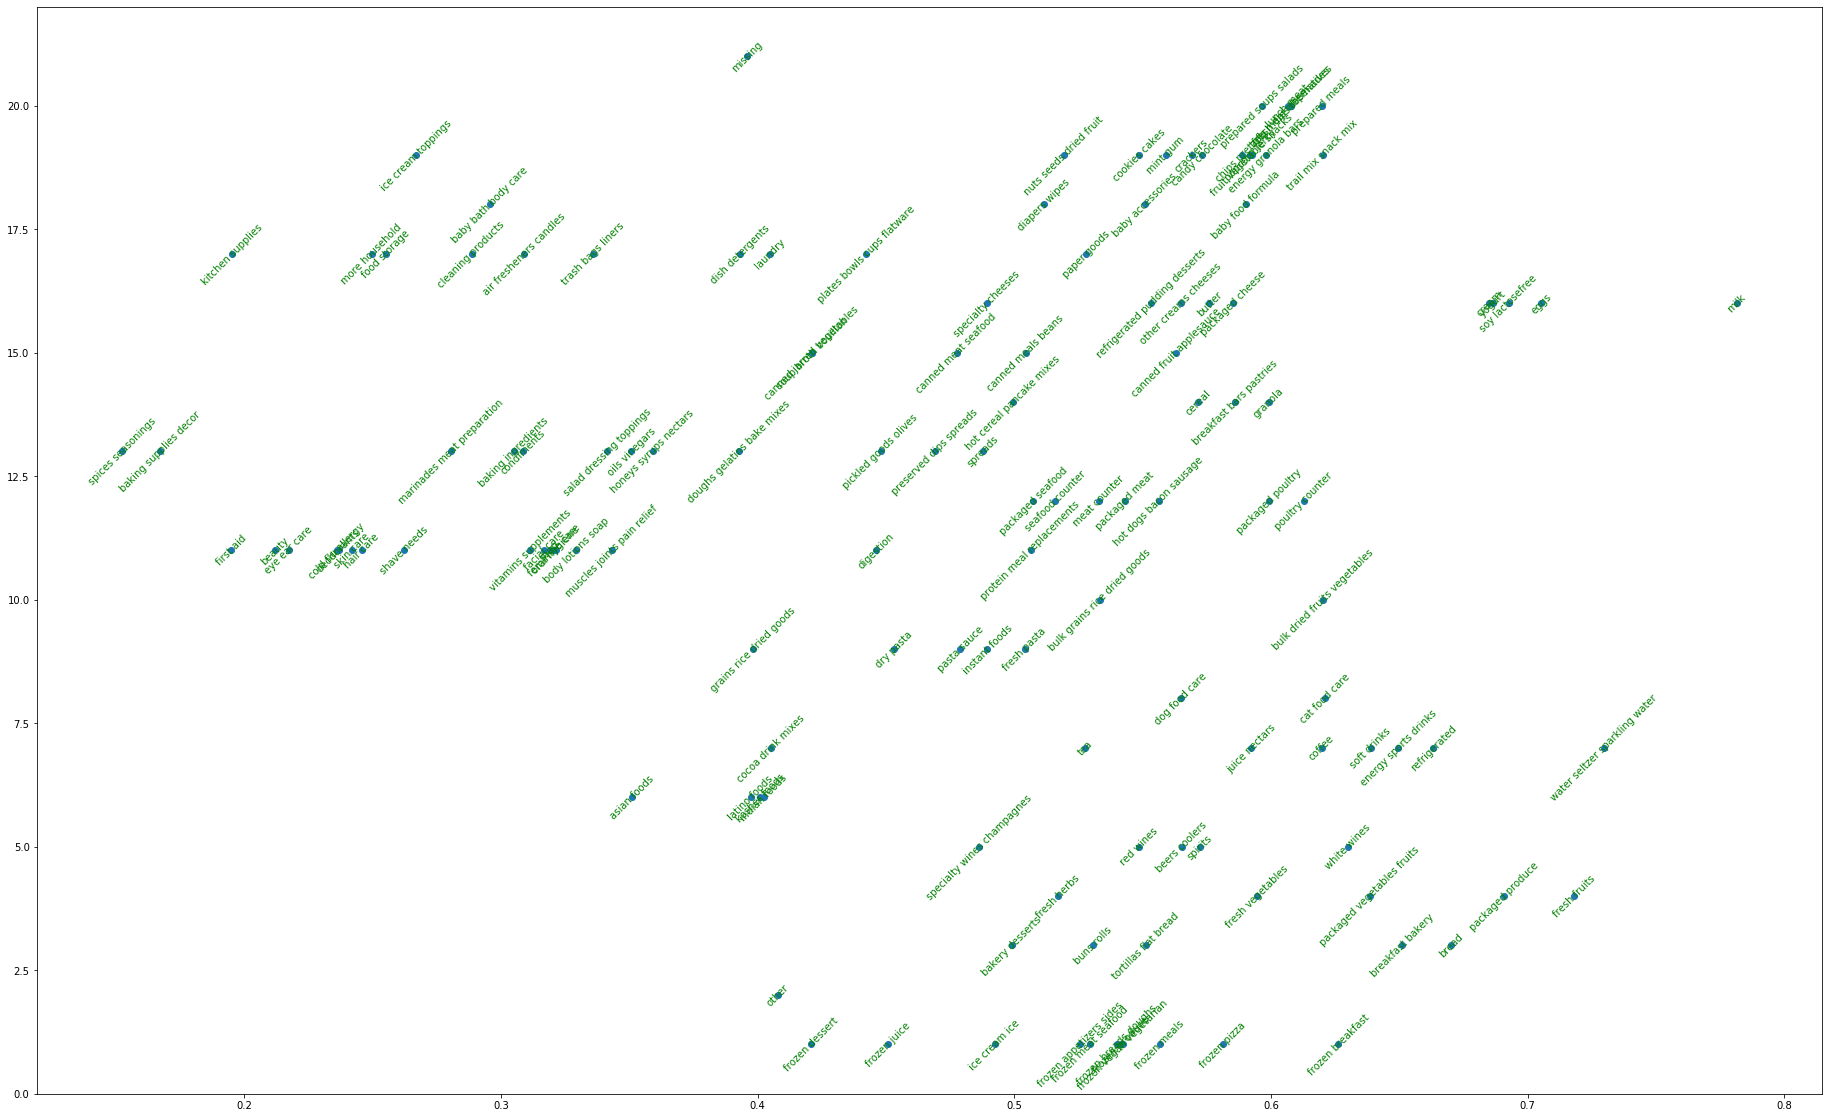

In [36]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(32,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.show()

### Agregar al carrito - Relación de pedidos:

Exploremos ahora la relación entre cómo el orden de agregar el producto al carrito afecta la tasa de reorden.

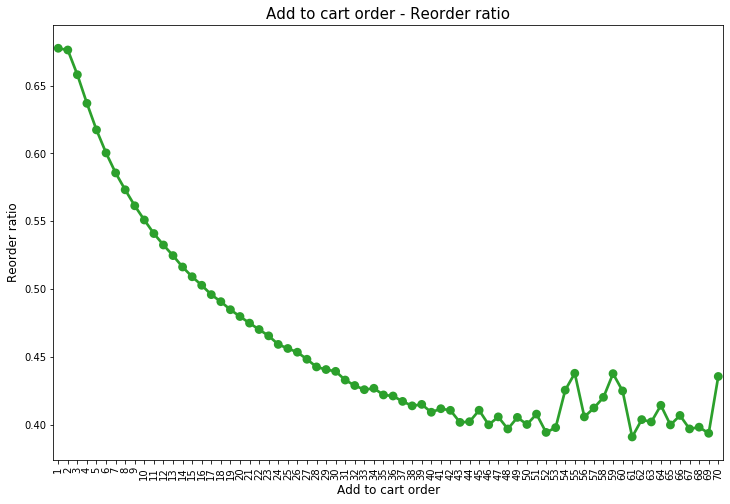

In [37]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

# ¿Qué podemos interpretar de este gráfico? ¿Hay alguna relación a la probabilidad de volver a elegir dicho producto?


### Existe una clara correlación entre la tasa de reorden o recompra y el orden en el que se agragan productos al carrito, la cual empieza a disvariar un poco después del lugar 50.

---


### Reordenar la proporción por variables basadas en el tiempo:

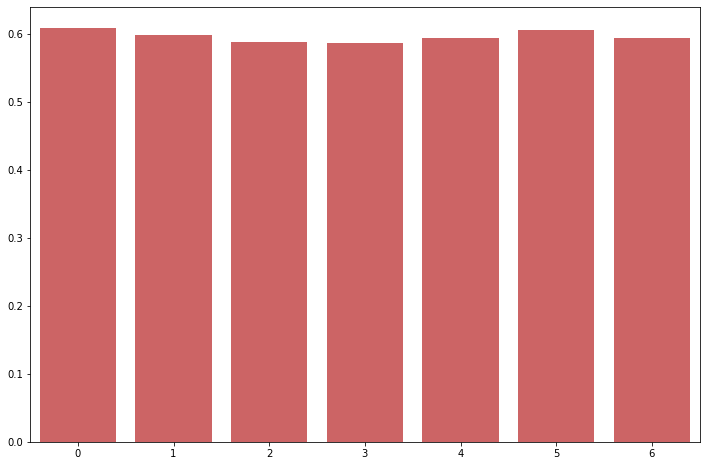

In [38]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.show()

Text(0.5, 0, 'Hour of day')

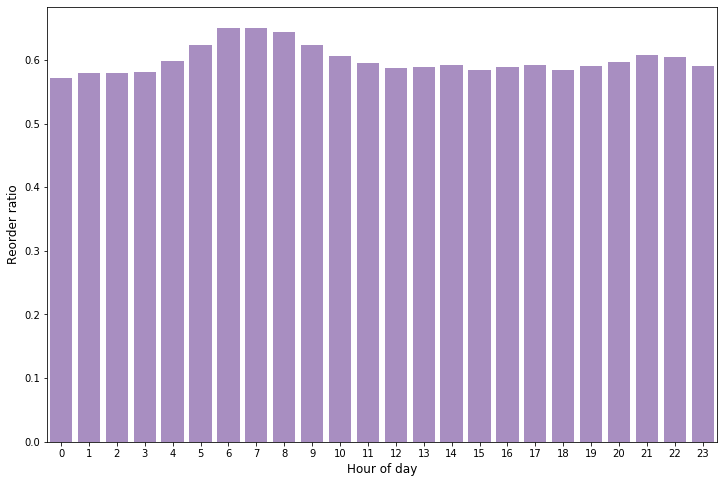

In [39]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)


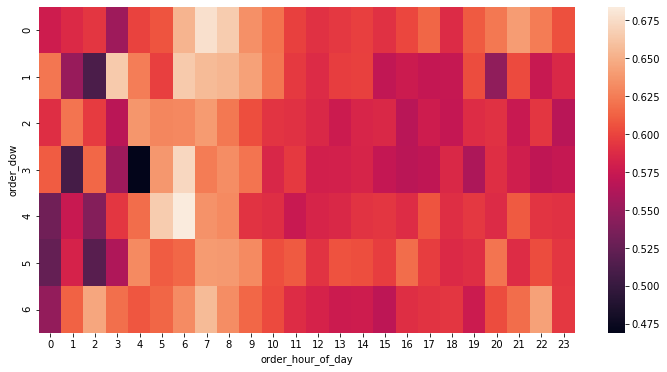

In [40]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)


# ¿Qué podemos inferir de todo lo anterior? ¿Las tasas de reordenar algo en qué momento del día tienen mayor frecuencia?


### Las tasas de reorden tienen un horario más temprano que las de compra, teniendo picos a las 6 y 7 de la mañana

----


In [42]:
## A partir del siguiente árbol de asociación... 
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

order_id  product_id  add_to_cart_order  reordered         product_name_x  \
0         2       33120                  1          1     Organic Egg Whites   
1         2       28985                  2          1  Michigan Organic Kale   
2         2        9327                  3          0          Garlic Powder   
3         2       45918                  4          1         Coconut Butter   
4         2       30035                  5          0      Natural Sweetener   

   aisle_id_x  department_id_x             aisle_x department_x  \
0          86               16                eggs   dairy eggs   
1          83                4    fresh vegetables      produce   
2         104               13   spices seasonings       pantry   
3          19               13       oils vinegars       pantry   
4          17               13  baking ingredients       pantry   

   add_to_cart_order_mod         product_name_y  aisle_id_y  department_id_y  \
0                      1     Organic Egg Whites          86               16   
1                      2  Michigan Organic Kale          83                4   
2                      3          Garlic Powder         104               13   
3                      4         Coconut Butter          19               13   
4                      5      Natural Sweetener          17               13   

            product_name  aisle_id  department_id             aisle_y  \
0     Organic Egg Whites        86             16                eggs   
1  Michigan Organic Kale        83              4    fresh vegetables   
2          Garlic Powder       104             13   spices seasonings   
3         Coconut Butter        19             13       oils vinegars   
4      Natural Sweetener        17             13  baking ingredients   

  department_y  
0   dairy eggs  
1      produce  
2       pantry  
3       pantry  
4       pantry

In [43]:
test = order_products_prior_df.sample(n = 1500)  

In [44]:
test

order_id  product_id  add_to_cart_order  reordered  \
30963864   3266099       40593                 11          0   
19691544   2076837       32467                 18          1   
8198066     865352       33000                  2          1   
5589243     589950       44233                  8          0   
27946674   2946967       13944                  8          1   
...            ...         ...                ...        ...   
240770       25389       33087                  7          0   
1884776     198719       24852                  7          1   
29824817   3145689        6187                 18          0   
3783971     399632       45475                  2          0   
17408147   1836275       28601                  2          1   

                         product_name_x  aisle_id_x  department_id_x  \
30963864                   Cream Cheese         108               16   
19691544  Organic Living Butter Lettuce          83                4   
8198066               Pure Irish Butter          36               16   
5589243          Multi Grain Crispbread          78               19   
27946674                     Pure Water         115                7   
...                                 ...         ...              ...   
240770                        Nectarine          24                4   
1884776                          Banana          24                4   
29824817             Raisin Bran Cereal         121               14   
3783971           Berry Sparkling Water         115                7   
17408147                 Collard Greens          83                4   

                                aisle_x department_x  add_to_cart_order_mod  \
30963864           other creams cheeses   dairy eggs                     11   
19691544               fresh vegetables      produce                     18   
8198066                          butter   dairy eggs                      2   
5589243                        crackers       snacks                      8   
27946674  water seltzer sparkling water    beverages                      8   
...                                 ...          ...                    ...   
240770                     fresh fruits      produce                      7   
1884776                    fresh fruits      produce                      7   
29824817                         cereal    breakfast                     18   
3783971   water seltzer sparkling water    beverages                      2   
17408147               fresh vegetables      produce                      2   

                         product_name_y  aisle_id_y  department_id_y  \
30963864                   Cream Cheese         108               16   
19691544  Organic Living Butter Lettuce          83                4   
8198066               Pure Irish Butter          36               16   
5589243          Multi Grain Crispbread          78               19   
27946674                     Pure Water         115                7   
...                                 ...         ...              ...   
240770                        Nectarine          24                4   
1884776                          Banana          24                4   
29824817             Raisin Bran Cereal         121               14   
3783971           Berry Sparkling Water         115                7   
17408147                 Collard Greens          83                4   

                           product_name  aisle_id  department_id  \
30963864                   Cream Cheese       108             16   
19691544  Organic Living Butter Lettuce        83              4   
8198066               Pure Irish Butter        36             16   
5589243          Multi Grain Crispbread        78             19   
27946674                     Pure Water       115              7   
...                                 ...       ...            ...   
240770                        Nectarine        24              4   
1884776           

In [47]:
import plotly.express as px 

##puede ser que vayan con '_x' o sin '_x' dependiendo de cómo se haya hecho el merge en el resultado de test arriba
    
fig = px.treemap(test, path=['department_x', 'product_name_x'], 
                 values='add_to_cart_order') 
  
fig.show()

¿Cuántos productos únicos se ofrecen en cada departamento / pasillo?

El tamaño de las cajas muestra la cantidad de productos en cada categoría.

### Aquí su respuesta
- Produce: 3210
- Dairy / eggs: 2060
- Snacks: 1323
- Beverages: 1104
- Frozen: 1046
- Pantry: 756
- Dry goods pasta: 535 
- Canned goods: 498
- Deli: 474
- Household: 440 
- Breakfast: 415
- Personal care: 200 
- International: 187
- Meat seafood: 178
- Babies: 125
- Pets: 56
- Alcohol: 27
- Missing: 23
- Other: 20
### Da una breve explicación de los primeros 3 recuadros
- Produce: Frutas y verduras, alimentos de campo
- Dairy: Alimentos lácteos y huevos
- Snacks: Alimentos de consumo rápido y dulces